<a href="https://colab.research.google.com/github/dwiputri-git/employee-promotion-ml-project/blob/main/notebooks/04_model_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Import Library & Load Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, recall_score, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load data hasil feature engineering
df = pd.read_csv('Promotion Dataset_Features Final.csv')

print("Data shape:", df.shape)
df.head()

Data shape: (939, 15)


,Age,Years_at_Company,Performance_Score,Leadership_Score,Training_Hours,Projects_Handled,Peer_Review_Score,Current_Position_Level,Promotion_Eligible,Training Level,Leadership_Level,Project_Level,Tenure_Level,Age_Group,Project_per_Years_log
0,24.0,21.000000,2.0,44.0,42.0,19.0,61.0,Junior,0,Low,Medium,High,Senior,Young,0.622530
1,50.0,8.000000,5.0,45.0,66.0,11.0,6.0,Junior,0,Low,Medium,Very High,New,Senior,0.798508
2,56.0,9.000000,5.0,19.0,96.0,6.0,86.0,Lead,0,Moderate,Low,Moderate,Mid,Senior,0.470004
3,39.0,24.000000,4.0,51.0,16.0,6.0,52.0,Senior,0,Very Low,High,Low,Veteran,Early Mid,0.215111
4,41.0,14.900332,4.0,64.0,57.0,16.0,59.0,Junior,0,Low,High,High,Mid,Early Mid,0.696276


In [2]:
# 2. Splitting Data
target_col = 'Promotion_Eligible'

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (751, 14), Test size: (188, 14)


In [3]:
# Cek Distribusi Kelas & Hitung Class Weight Otomatis
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Distribusi kelas di training:")
print(y_train.value_counts(normalize=True) * 100)

print("\nBobot kelas otomatis (class_weight='balanced'):")
for k, v in class_weights.items():
    print(f"  Kelas {k}: {v:.2f}x lebih penting")

# Tampilkan dalam DataFrame
pd.DataFrame({
  'Kelas': classes,
  'Proporsi (%)': y_train.value_counts(normalize=True).sort_index().values * 100,
  'Bobot (weight)': weights
})


Distribusi kelas di training:
Promotion_Eligible
0    70.57257
1    29.42743
Name: proportion, dtype: float64

Bobot kelas otomatis (class_weight='balanced'):
  Kelas 0: 0.71x lebih penting
  Kelas 1: 1.70x lebih penting


,Kelas,Proporsi (%),Bobot (weight)
0,0,70.57257,0.708491
1,1,29.42743,1.699095


In [4]:
# 3. Pipeline Setup
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Pisahkan kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Preprocessor: scaling numerik + encoding kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Pipeline utama: preprocessing + model
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])


In [5]:
# 4. Hyperparameter Tuning (Recall)

param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 5, 7, 9, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# Use recall as the main metric
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search with the pipeline
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Recall:", grid_search.best_score_)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits

Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5}
Best Cross-Validation Recall: 0.6150505050505051


=== MODEL EVALUATION REPORT ===


,Metric,Train,Test
0,Accuracy,0.454,0.399
1,Precision,0.347,0.312
2,Recall,0.968,0.873
3,F1-Score,0.511,0.459
4,ROC-AUC,0.604,0.538
5,MSE,0.546,0.601


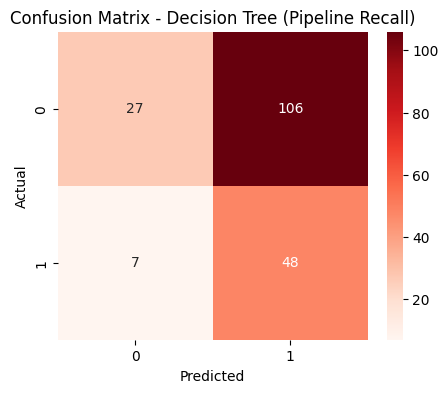

In [6]:
# 5. Evaluasi Best Model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, mean_squared_error, classification_report
)

best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)


# Hitung metrik
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "MSE"],
    "Train": [
        accuracy_score(y_train, y_pred_train),
        precision_score(y_train, y_pred_train),
        recall_score(y_train, y_pred_train),
        f1_score(y_train, y_pred_train),
        roc_auc_score(y_train, y_pred_train),
        mean_squared_error(y_train, y_pred_train)
    ],
    "Test": [
        accuracy_score(y_test, y_pred_test),
        precision_score(y_test, y_pred_test),
        recall_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test),
        roc_auc_score(y_test, y_pred_test),
        mean_squared_error(y_test, y_pred_test)
    ]
}

df_metrics = pd.DataFrame(metrics)
print("=== MODEL EVALUATION REPORT ===")
display(df_metrics.round(3))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Decision Tree (Pipeline Recall)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
import os
import joblib

# Create the directory if it doesn't exist
output_dir = 'model'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

joblib.dump(best_model, os.path.join(output_dir, 'decision_tree_pipeline_best_recall.pkl'))
print(f"Model pipeline terbaik disimpan di: {os.path.join(output_dir, 'decision_tree_pipeline_best_recall.pkl')}")

Model pipeline terbaik disimpan di: model/decision_tree_pipeline_best_recall.pkl
